# Visualizer
### Use this script to visualize the neuron traces according to the paper "A Generalized Linear Integrate-and-Fire Neural Model Produces Diverse Spiking Behaviors" by Stefan Mihalas and Ernst Niebur. Further, data was created with a fix length of 1sec (1ms time steps), with noise on the input current, and/or temporal jitter on the time point of the step for dynamic inputs. 

### The script will also calculate the inter-spike intervalls (ISIs) for a single trial and for all repeating trials, whenever possible. For repeating trials, all ISIs are grouped and further statics represent the outcome of all repetitions per class.

In [13]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly

from tactile_encoding.utils.utils import value2key, create_directory


In [14]:
path = './plots'  # set path to store plots
create_directory(path)  # create folder if not existent


In [15]:
max_trials = 100

classes_list = {
    'A': "Tonic spiking",
    'B': "Class 1",
    'C': "Spike frequency adaptation",
    'D': "Phasic spiking",
    'E': "Accommodation",
    'F': "Threshold variability",
    'G': "Rebound spike",
    'H': "Class 2",
    'I': "Integrator",
    'J': "Input bistability",
    'K': "Hyperpolarizing spiking",
    'L': "Hyperpolarizing bursting",
    'M': "Tonic bursting",
    'N': "Phasic bursting",
    'O': "Rebound burst",
    'P': "Mixed mode",
    'Q': "Afterpotentials",
    'R': "Basal bistability",
    'S': "Preferred frequency",
    'T': "Spike latency",
}


In [16]:
def indices_of_sign_change(data):
    """
    Returns indices of sign change in list.
    """
    idc = []
    for idx in range(0, len(data) - 1):
        # checking for successive opposite index
        if data[idx] > 0 and data[idx + 1] < 0 or data[idx] < 0 and data[idx + 1] > 0:
            idc.append(idx)
    
    return idc

In [17]:
def two_scales(ax1, time, data1, data2, data3, c1, c2, c3, create_xlabel=False, create_ylabel1=False, create_ylabel2=False):
    """
    Creates subplot with shared x axis and 2 y axis.
    """
    ax2 = ax1.twinx()

    # plot voltage trace
    ax1.plot(time, data1, color=c1)

    # input current trace
    ax2.plot(time, data2, color=c2, alpha=0.6)

    # spike times at peak of voltage trace
    # TODO check spike times! Now the v at t-1 is selected
    ax1.scatter(np.where(data3 == 1)[0], data1[np.where(
        data3 == 1)-np.ones_like(np.where(data3 == 1))], s=15, color=c3)

    # TODO set tick size
    # ax1.set_xticks(fontsize=8)
    # create labels if needed
    if create_xlabel:
        ax1.set_xlabel('time (s)')
    if create_ylabel1:
        ax1.set_ylabel('voltage (V)')
    if create_ylabel2:
        ax2.set_ylabel('current (I)')

    return ax1, ax2


In [18]:
def plot_traces_original(path, data, add_noise=False, temp_jitter=False):
    """
    Creates the input current and membrane voltage traces for the original data.
    """
    figname = 'Original traces'
    if add_noise:
        figname = figname + ' - noisy'
    if temp_jitter:
        figname = figname + ' - temp jitter'
    plt.figure(figsize=(12, 12))
    plt.suptitle(figname)
    for num, el in enumerate(list(classes_list.values())):
        ax = plt.subplot(5, 4, num+1)
        plt.title("{} ({})".format(el, value2key(
            el, classes_list)), fontsize=10)

        # raster plot
        spikes = np.reshape(np.array(data[num][0]), (np.array(
            data[num][0]).shape[0]))

        # voltage trace
        voltage = np.reshape(np.array(data[num][1]), (np.array(
            data[num][1]).shape[0]))

        # input current trace
        input_current = np.reshape(np.array(data[num][2]), (np.array(
            data[num][2]).shape[0]))

        # only add labels on most outer subplot
        # create left y label
        if num == 0 or num == 4 or num == 8 or num == 12:
            ax1, ax2 = two_scales(ax, range(1, len(voltage)+1), voltage, input_current, spikes, 'b',
                                  'orange', 'r', create_xlabel=False, create_ylabel1=True, create_ylabel2=False)
        # create right y label
        elif num == 3 or num == 7 or num == 11 or num == 15:
            ax1, ax2 = two_scales(ax, range(1, len(voltage)+1), voltage, input_current, spikes, 'b',
                                  'orange', 'r', create_xlabel=False, create_ylabel1=False, create_ylabel2=True)
        # create left y label and x label
        elif num == 16:
            ax1, ax2 = two_scales(ax, range(1, len(voltage)+1), voltage, input_current, spikes,
                                  'b', 'orange', 'r', create_xlabel=True, create_ylabel1=True, create_ylabel2=False)
        # create x label
        elif num > 16 and num < 19:
            ax1, ax2 = two_scales(ax, range(1, len(voltage)+1), voltage, input_current, spikes, 'b',
                                  'orange', 'r', create_xlabel=True, create_ylabel1=False, create_ylabel2=False)
        # create right y label and x label
        elif num == 19:
            ax1, ax2 = two_scales(ax, range(1, len(voltage)+1), voltage, input_current, spikes,
                                  'b', 'orange', 'r', create_xlabel=True, create_ylabel1=False, create_ylabel2=True)
        # create no label
        else:
            ax1, ax2 = two_scales(ax, range(1, len(voltage)+1), voltage, input_current, spikes, 'b',
                                  'orange', 'r', create_xlabel=False, create_ylabel1=False, create_ylabel2=False)

    filepath = f'{path}/traces_original'
    if add_noise:
        filepath = filepath + '_noisy'
    if temp_jitter:
        filepath = filepath + '_temp_jitter'
    plt.tight_layout()
    plt.savefig(f'{filepath}.png', dpi=300)


In [19]:
def plot_isi_original(path, data, add_noise=False, temp_jitter=False, norm_count=False, norm_time=False):
    """
    Calculates and plots the ISI for the original data.
    """
    figname = 'ISI original'
    if add_noise:
        figname = figname + ' - noisy'
    if temp_jitter:
        figname = figname + ' - temp jitter'
    plt.figure(figsize=(12, 12))
    plt.suptitle(figname)
    for num, el in enumerate(list(classes_list.values())):
        plt.subplot(5, 4, num+1)
        plt.title("{} ({})".format(el, value2key(
            el, classes_list)), fontsize=10)
        # TODO inlcude grid to all plots
        # plt.grid()

        # cal ISI
        spikes = np.reshape(np.array(data[num][0]), (np.array(
            data[num][0]).shape[0]))
        isi_original = np.diff(np.where(spikes == 1)[0])

        # calc hist if ISI found
        if len(isi_original) > 0:
            tmp_original = np.unique(isi_original, return_counts=True)
            isi_original = tmp_original[0]
            if norm_time:
                isi_original = isi_original/max(isi_original)
            isi_original_count = tmp_original[1]
            if norm_count:
                isi_original_count = isi_original_count/max(isi_original_count)
            # fit curve to ISI hist
            # idc_sign_change = indices_of_sign_change(
            #     np.diff(isi_original_count))
            # degree = len(idc_sign_change)+5
            # fitted_curve = poly.polyfit(
            #     isi_original, isi_original_count, deg=degree)
            # y_val = poly.polyval(isi_original, fitted_curve)
            # plt.plot(isi_original, y_val, color='r')
            if norm_time:
                plt.bar(isi_original, isi_original_count, width=0.01)
                plt.xlim((0, 1.1))
            else:
                plt.bar(isi_original, isi_original_count)
        else:
            plt.text(0.3, 0.5, f'nbr. spikes = {len(np.where(spikes == 1))}')
        plt.tick_params(axis='x', labelsize=6)
        plt.tick_params(axis='y', labelsize=6)

        # only add labels on most outer subplot
        if num == 0 or num == 4 or num == 8 or num == 12:
            if norm_count:
                plt.ylabel(r'\overline{count}')
            else:
                plt.ylabel('count')
        elif num == 16:
            if norm_time:
                plt.xlabel(r'\overline{ISI}')
            else:
                plt.xlabel('ISI (ms)')
            if norm_count:
                plt.ylabel(r'\overline{count}')
            else:
                plt.ylabel('count')
        elif num > 16:
            if norm_time:
                plt.xlabel(r'\overline{ISI}')
            else:
                plt.xlabel('ISI (ms)')

    filepath = f'{path}/isi_original'
    if add_noise:
        filepath = filepath + '_noisy'
    if temp_jitter:
        filepath = filepath + '_temp_jitter'

    plt.tight_layout()
    plt.savefig(f'{filepath}.png', dpi=300)


In [20]:
def plot_traces_fix_len(path, data, max_trials, add_noise=False, temp_jitter=False):
    """
    Creates the input current and membrane voltage traces for the data with fix length.
    """
    figname = 'Fix length traces'
    if add_noise:
        figname = figname + ' - noisy'
    if temp_jitter:
        figname = figname + ' - temp jitter'
    plt.figure(figsize=(12, 12))
    plt.suptitle(figname)
    for num, el in enumerate(list(classes_list.values())):
        # select a sample trial out of max_trials
        pos = range(num*max_trials, num*max_trials+max_trials)
        pos = np.random.choice(pos)

        ax = plt.subplot(5, 4, num+1)
        plt.title("{} ({})".format(el, value2key(
            el, classes_list)), fontsize=10)

        # get spike times
        spikes = np.reshape(np.array(data[pos][0]), (np.array(
            data[pos][0]).shape[0]))

        # voltage trace
        voltage = np.reshape(np.array(data[pos][1]), (np.array(
            data[pos][1]).shape[0]))

        # input current trace
        input_current = np.reshape(np.array(data[pos][2]), (np.array(
            data[pos][2]).shape[0]))

        # only add labels on most outer subplot
        # create left y label
        if num == 0 or num == 4 or num == 8 or num == 12:
            ax1, ax2 = two_scales(ax, range(1, len(voltage)+1), voltage, input_current, spikes, 'b',
                                  'orange', 'r', create_xlabel=False, create_ylabel1=True, create_ylabel2=False)
        # create right y label
        elif num == 3 or num == 7 or num == 11 or num == 15:
            ax1, ax2 = two_scales(ax, range(1, len(voltage)+1), voltage, input_current, spikes, 'b',
                                  'orange', 'r', create_xlabel=False, create_ylabel1=False, create_ylabel2=True)
        # create left y label and x label
        elif num == 16:
            ax1, ax2 = two_scales(ax, range(1, len(voltage)+1), voltage, input_current, spikes,
                                  'b', 'orange', 'r', create_xlabel=True, create_ylabel1=True, create_ylabel2=False)
        # create x label
        elif num > 16 and num < 19:
            ax1, ax2 = two_scales(ax, range(1, len(voltage)+1), voltage, input_current, spikes, 'b',
                                  'orange', 'r', create_xlabel=True, create_ylabel1=False, create_ylabel2=False)
        # create right y label and x label
        elif num == 19:
            ax1, ax2 = two_scales(ax, range(1, len(voltage)+1), voltage, input_current, spikes,
                                  'b', 'orange', 'r', create_xlabel=True, create_ylabel1=False, create_ylabel2=True)
        # create no label
        else:
            ax1, ax2 = two_scales(ax, range(1, len(voltage)+1), voltage, input_current, spikes, 'b',
                                  'orange', 'r', create_xlabel=False, create_ylabel1=False, create_ylabel2=False)

    filepath = f'{path}/traces_fix_len'
    if add_noise:
        filepath = filepath + '_noisy'
    if temp_jitter:
        filepath = filepath + '_temp_jitter'

    plt.tight_layout()
    plt.savefig(f'{filepath}.png', dpi=300)


In [21]:
def plot_single_isi_fix_len(path, data, max_trials, add_noise=False, temp_jitter=False, norm_time=False, norm_count=False):
    """
    Calculates and plots the ISI for a single random trial of the fix length data.
    """
    figname = 'ISI fix length single'
    if add_noise:
        figname = figname + ' - noisy'
    if temp_jitter:
        figname = figname + ' - temp jitter'
    plt.figure(figsize=(12, 12))
    plt.suptitle(figname)
    for num, el in enumerate(list(classes_list.values())):
        # select a sample trial out of max_trials
        pos = range(num*max_trials, num*max_trials+max_trials)
        pos = np.random.choice(pos)

        plt.subplot(5, 4, num+1)
        plt.title("{} ({})".format(el, value2key(
            el, classes_list)), fontsize=10)
        # TODO inlcude grid to all plots
        # plt.grid()

        # calc ISI
        spikes = np.reshape(np.array(data[pos][0]), (np.array(
            data[pos][0]).shape[0]))
        isi_fix_len = np.diff(np.where(spikes == 1)[0])

        # calc hist if ISI found
        if len(isi_fix_len) > 0:
            tmp_fix_len = np.unique(isi_fix_len, return_counts=True)
            isi_fix_len = tmp_fix_len[0]
            if norm_time:
                isi_fix_len = isi_fix_len/max(isi_fix_len)
            isi_fix_len_count = tmp_fix_len[1]
            if norm_count:
                isi_fix_len_count = isi_fix_len_count/max(isi_fix_len_count)
            # # fit curve to ISI hist
            # idc_sign_change = indices_of_sign_change(
            #     np.diff(isi_fix_len_count))
            # degree = len(idc_sign_change)+5
            # fitted_curve = poly.polyfit(
            #     isi_fix_len, isi_fix_len_count, deg=degree)
            # y_val = poly.polyval(isi_fix_len, fitted_curve)
            # plt.plot(isi_fix_len, y_val, color='r')
            if norm_time:
                plt.bar(isi_fix_len, isi_fix_len_count, width=0.01)
                plt.xlim((0, 1.1))
            else:
                plt.bar(isi_fix_len, isi_fix_len_count)
        else:
            plt.text(0.3, 0.5, f'nbr. spikes = {len(np.where(spikes == 1))}')
        plt.tick_params(axis='x', labelsize=6)
        plt.tick_params(axis='y', labelsize=6)

        # only add labels on most outer subplot
        if num == 0 or num == 4 or num == 8 or num == 12:
            if norm_count:
                plt.ylabel(r'\overline{count}')
            else:
                plt.ylabel('count')
        elif num == 16:
            if norm_time:
                plt.xlabel(r'\overline{ISI}')
            else:
                plt.xlabel('ISI (ms)')
            if norm_count:
                plt.ylabel(r'\overline{count}')
            else:
                plt.ylabel('count')
        elif num > 16:
            if norm_time:
                plt.xlabel(r'\overline{ISI}')
            else:
                plt.xlabel('ISI (ms)')

    filepath = f'{path}/isi_single_trial_fix_len'
    if norm_count:
        filepath = filepath + '_norm_count'
    if norm_count:
        filepath = filepath + '_norm_time'
    if add_noise:
        filepath = filepath + '_noisy'
    if temp_jitter:
        filepath = filepath + '_temp_jitter'

    plt.tight_layout()
    plt.savefig(f'{filepath}.png', dpi=300)


In [22]:
def plot_isi_fix_len(path, data, max_trials, add_noise=False, temp_jitter=False, norm_count=False, norm_time=False):
    """
    Calculates and plots the ISI for all repetitions of fix length data.
    """
    figname = 'ISI fix length all'
    if add_noise:
        figname = figname + ' - noisy'
    if temp_jitter:
        figname = figname + ' - temp jitter'
    plt.figure(figsize=(12, 12))
    plt.suptitle(figname)
    for num, el in enumerate(list(classes_list.values())):
        # concatenate all ISIs
        isi_fix_len = []
        for trial in range(max_trials):
            # calc spikes per trial
            spikes = np.reshape(np.array(data[trial + num*max_trials][0]), (np.array(
                data[trial + num*max_trials][0]).shape[0]))
            # calc ISI
            isi_fix_len.extend(np.diff(np.where(spikes == 1)[0]))

        plt.subplot(5, 4, num+1)
        plt.title("{} ({})".format(el, value2key(
            el, classes_list)), fontsize=10)

        # TODO inlcude grid to all plots
        # plt.grid()

        if len(isi_fix_len) > 0:
            tmp_fix_len = np.unique(isi_fix_len, return_counts=True)
            isi_fix_len = tmp_fix_len[0]
            if norm_time:
                isi_fix_len = isi_fix_len/max(isi_fix_len)
            isi_fix_len_count = tmp_fix_len[1]
            if norm_count:
                isi_fix_len_count = isi_fix_len_count/max(isi_fix_len_count)
            # # fit curve to ISI hist
            # idc_sign_change = indices_of_sign_change(
            #     np.diff(isi_fix_len_count))
            # degree = len(idc_sign_change)+5
            # fitted_curve = poly.polyfit(
            #     isi_fix_len, isi_fix_len_count, deg=degree)
            # y_val = poly.polyval(isi_fix_len, fitted_curve)
            # plt.plot(isi_fix_len, y_val, color='r')
            if norm_time:
                plt.bar(isi_fix_len, isi_fix_len_count, width=0.01)
                plt.xlim((0, 1.1))
            else:
                plt.bar(isi_fix_len, isi_fix_len_count)
        else:
            plt.text(0.3, 0.5, f'nbr. spikes = {len(np.where(spikes == 1))}')

        plt.tick_params(axis='x', labelsize=6)
        plt.tick_params(axis='y', labelsize=6)

        # only add labels on most outer subplot
        if num == 0 or num == 4 or num == 8 or num == 12:
            if norm_count:
                plt.ylabel(r'\overline{count}')
            else:
                plt.ylabel('count')
        elif num == 16:
            if norm_time:
                plt.xlabel(r'\overline{ISI}')
            else:
                plt.xlabel('ISI (ms)')
            if norm_count:
                plt.ylabel(r'\overline{count}')
            else:
                plt.ylabel('count')
        elif num > 16:
            if norm_time:
                plt.xlabel(r'\overline{ISI}')
            else:
                plt.xlabel('ISI (ms)')

    filepath = f'{path}/isi_fix_len'
    if add_noise:
        filepath = filepath + '_noisy'
    if temp_jitter:
        filepath = filepath + '_temp_jitter'

    plt.tight_layout()
    plt.savefig(f'{filepath}.png', dpi=300)


## Original data (with noise and temporal jitter)

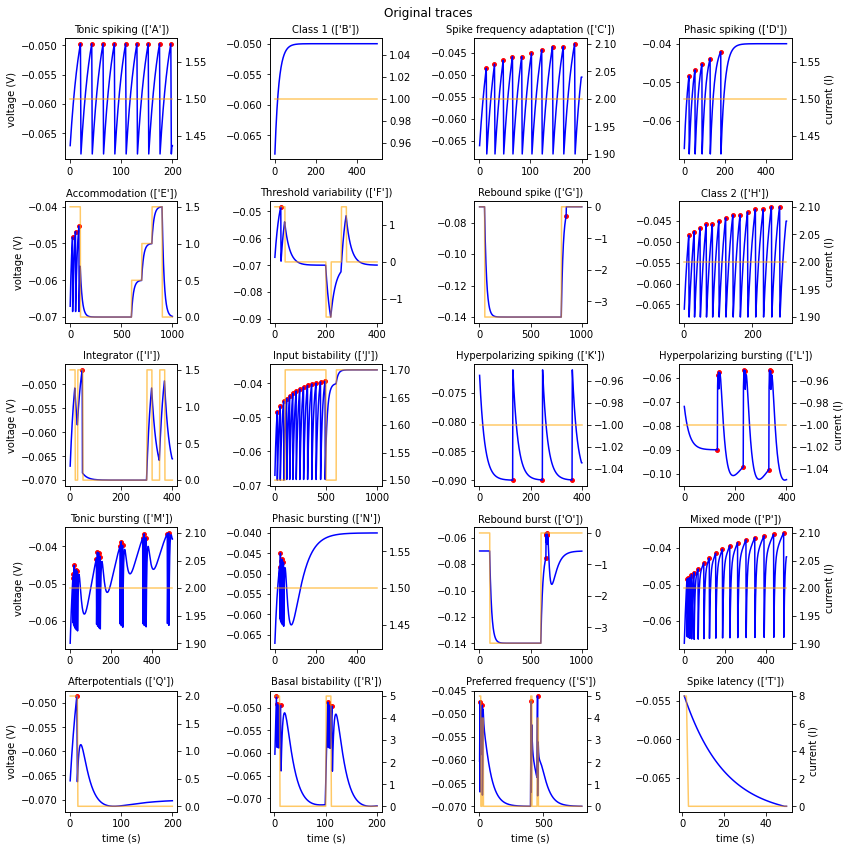

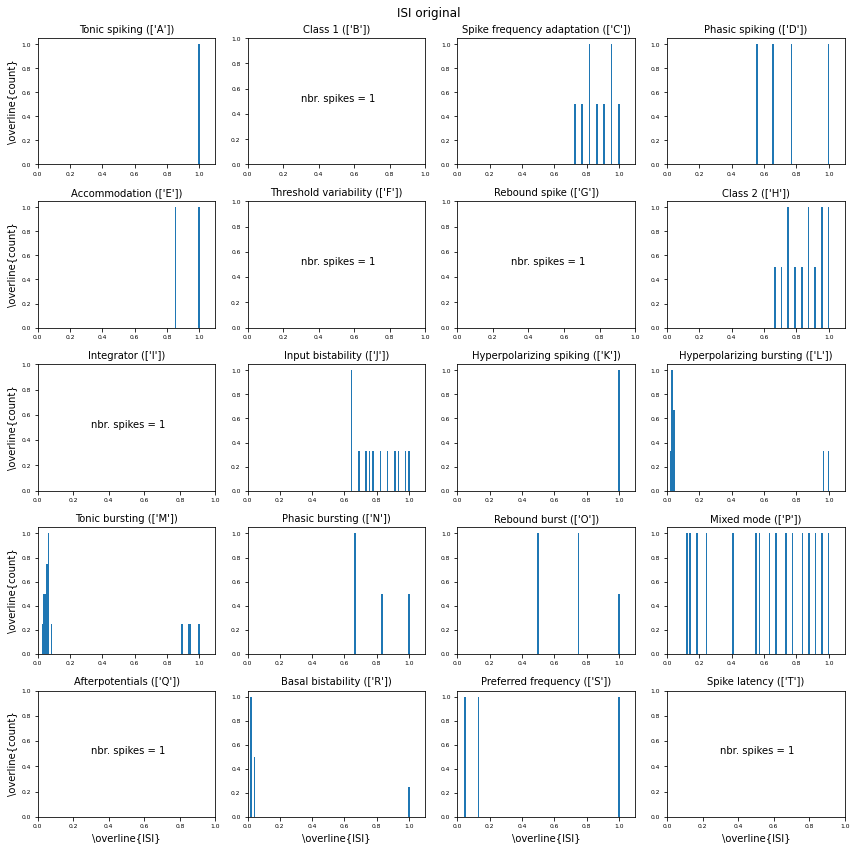

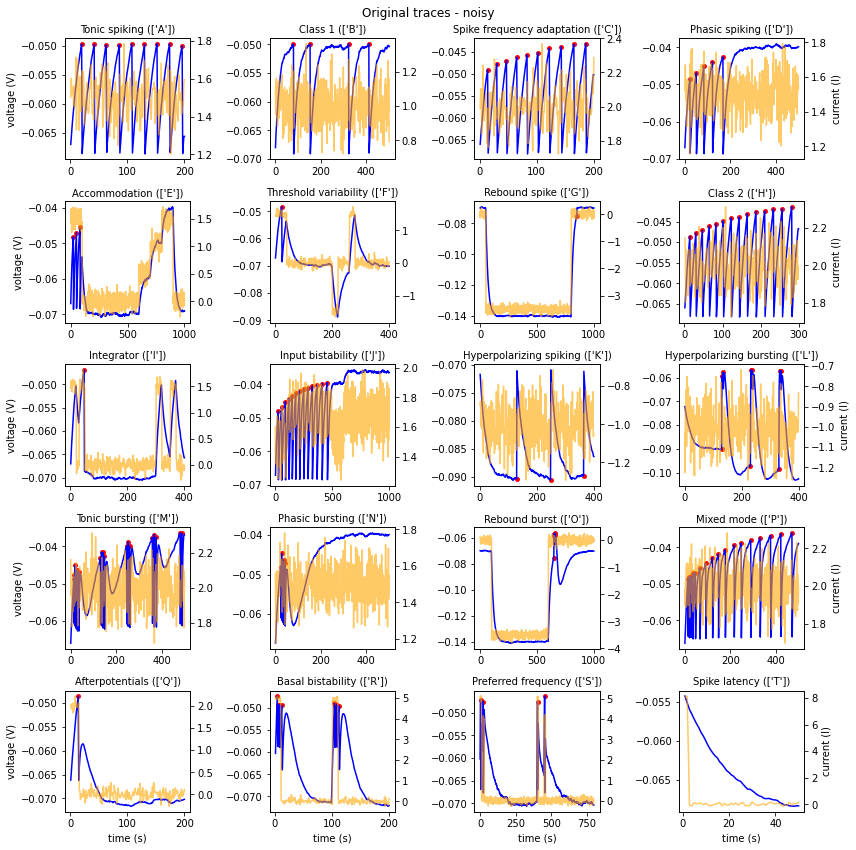

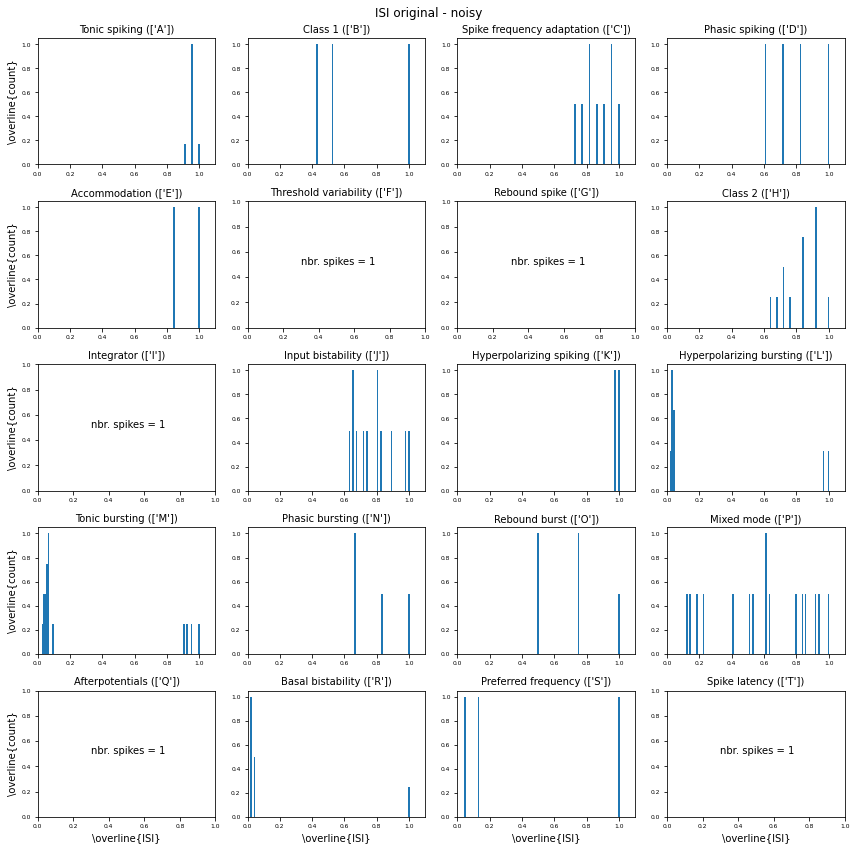

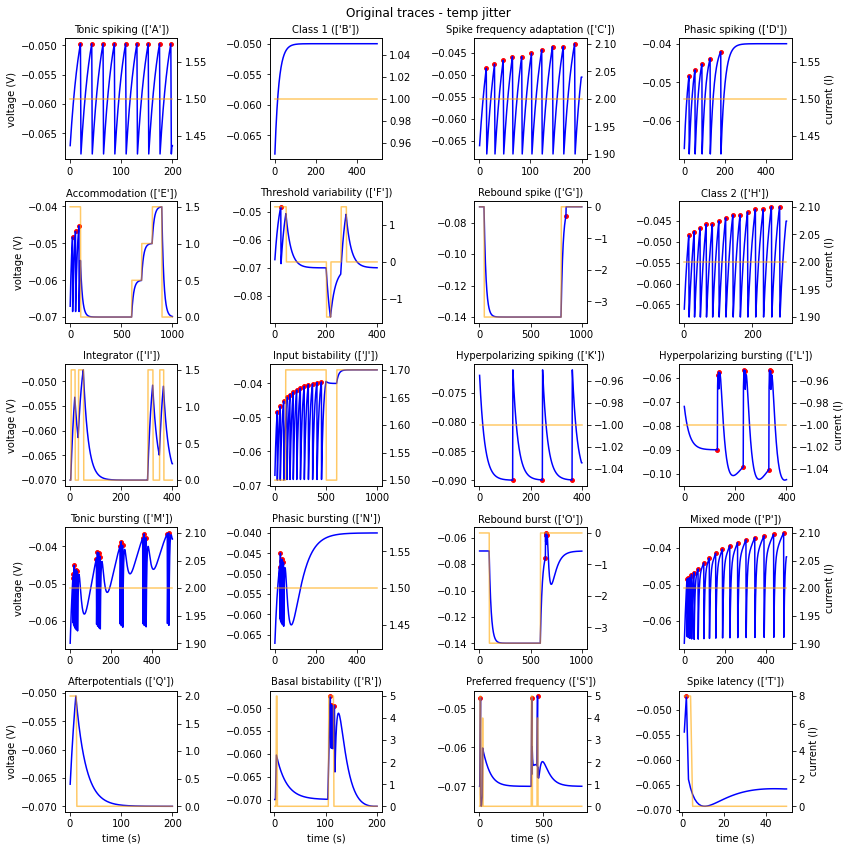

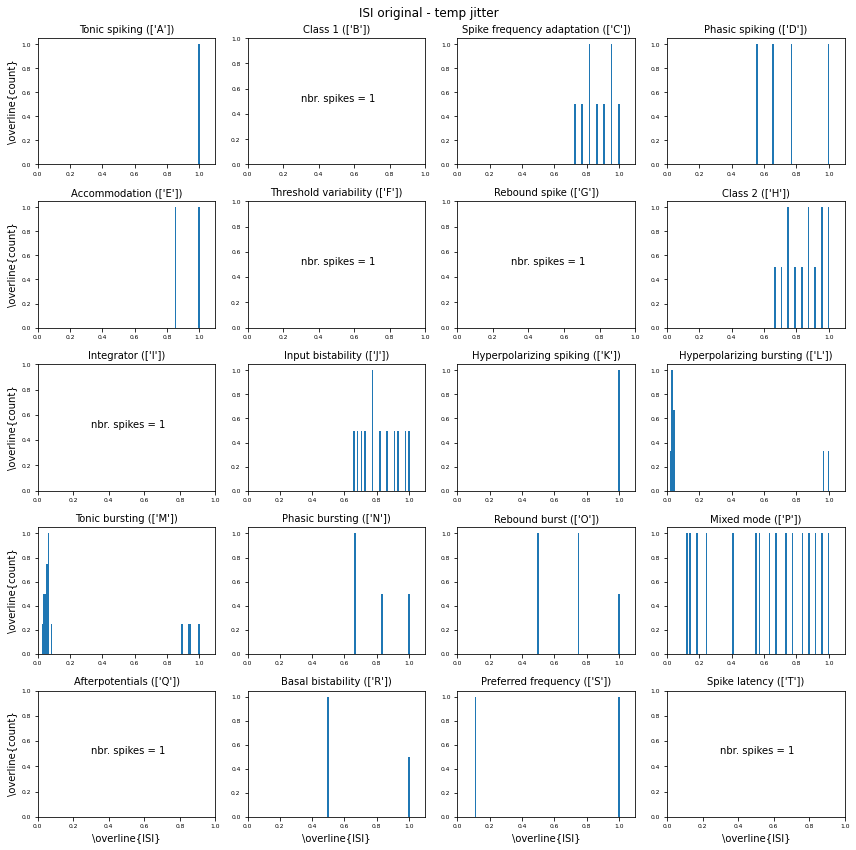

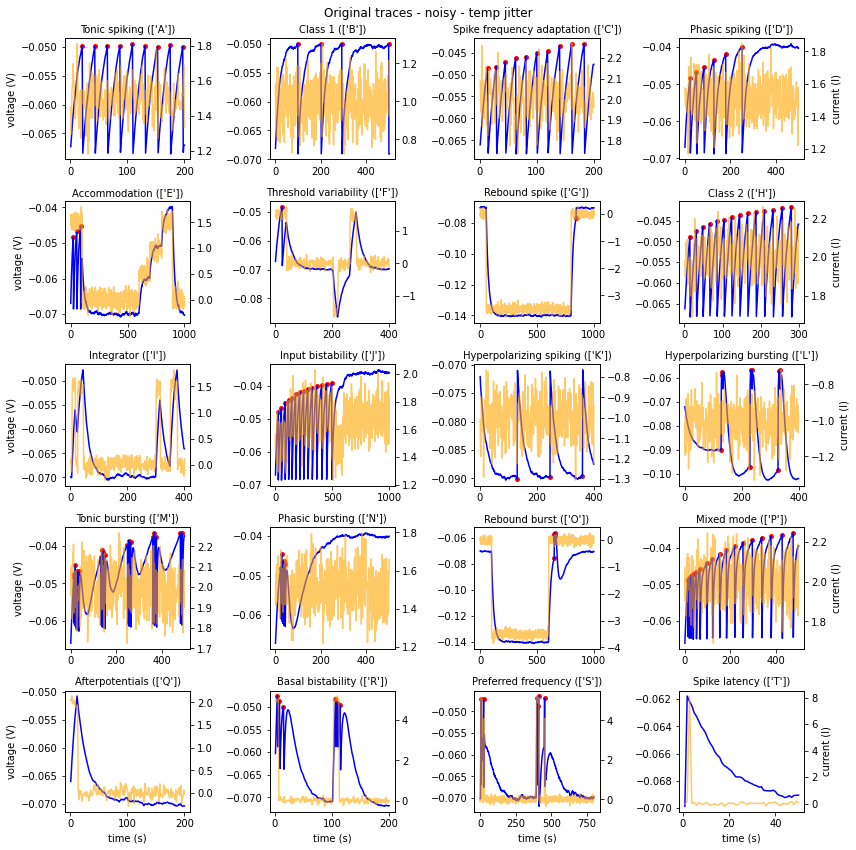

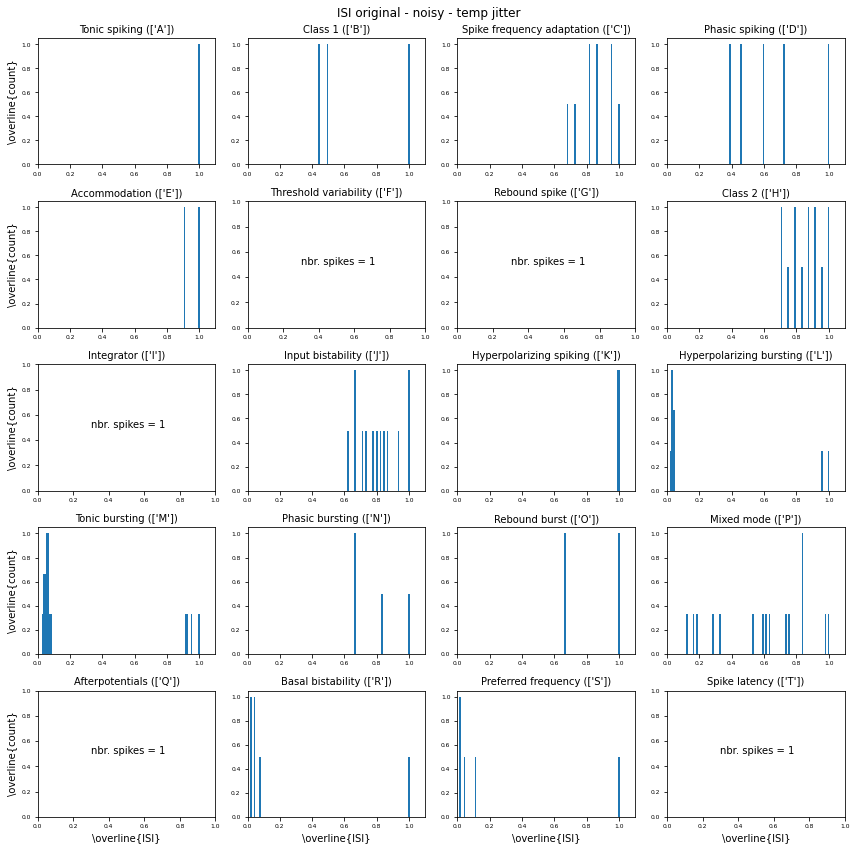

In [23]:
data_types = ['', '_noisy', '_temp_jitter', '_noisy_temp_jitter']

for _, data_type in enumerate(data_types):
    add_noise = False
    temp_jitter = False

    # set correct flags
    if data_type == '_noisy':
        add_noise = True
    elif data_type == '_temp_jitter':
        temp_jitter = True
    elif data_type == '_noisy_temp_jitter':
        add_noise = True
        temp_jitter = True

    # load data
    filename = 'data_encoding_original' + data_type
    infile = open(f"./data/{filename}.pkl", 'rb')
    data = pickle.load(infile)
    infile.close()

    # create plots
    plot_traces_original(path, data, add_noise=add_noise,
                         temp_jitter=temp_jitter)
    plot_isi_original(path, data, add_noise=add_noise,
                      temp_jitter=temp_jitter, norm_count=False, norm_time=False)
    plot_isi_original(path, data, add_noise=add_noise,
                      temp_jitter=temp_jitter, norm_count=True, norm_time=False)
    plot_isi_original(path, data, add_noise=add_noise,
                      temp_jitter=temp_jitter, norm_count=True, norm_time=True)


# Fix length data (with noise and temporal jitter)

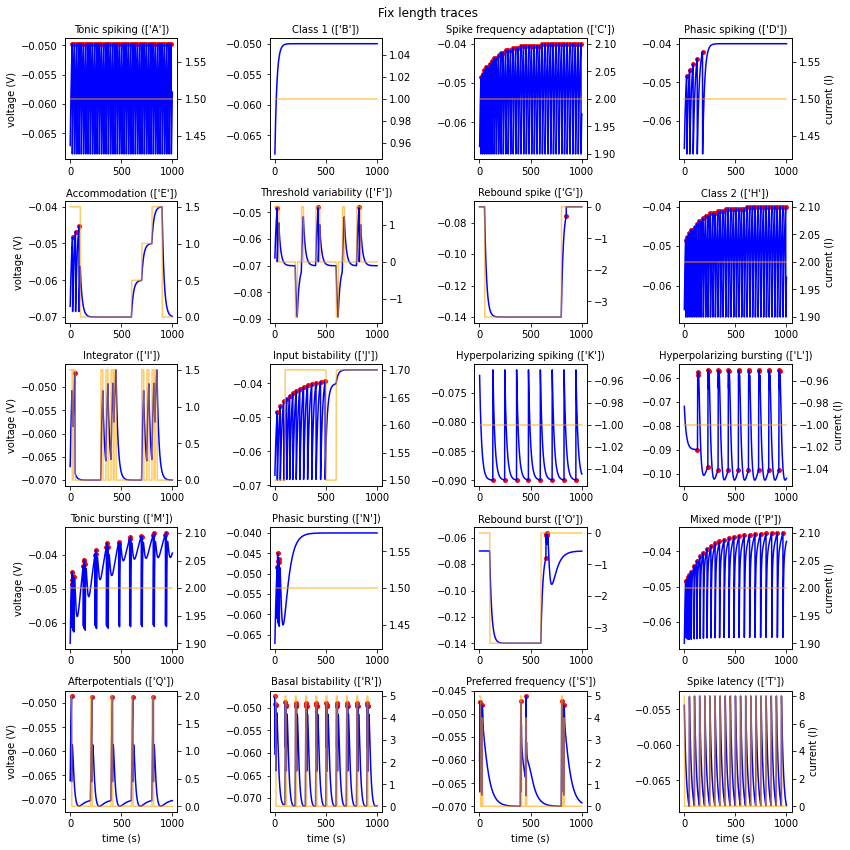

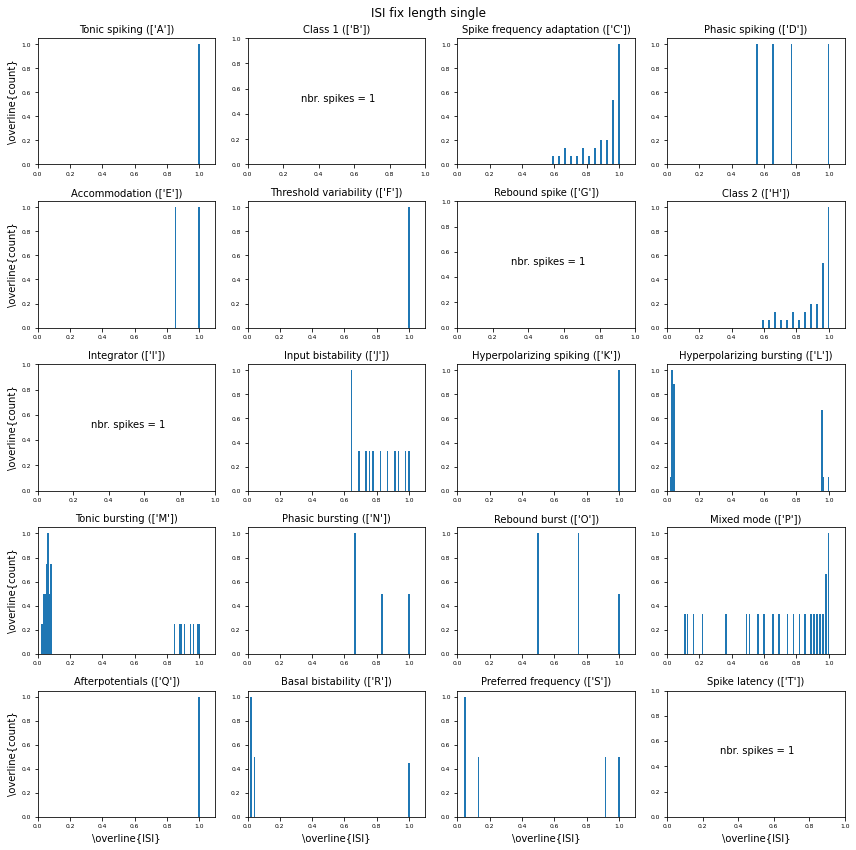

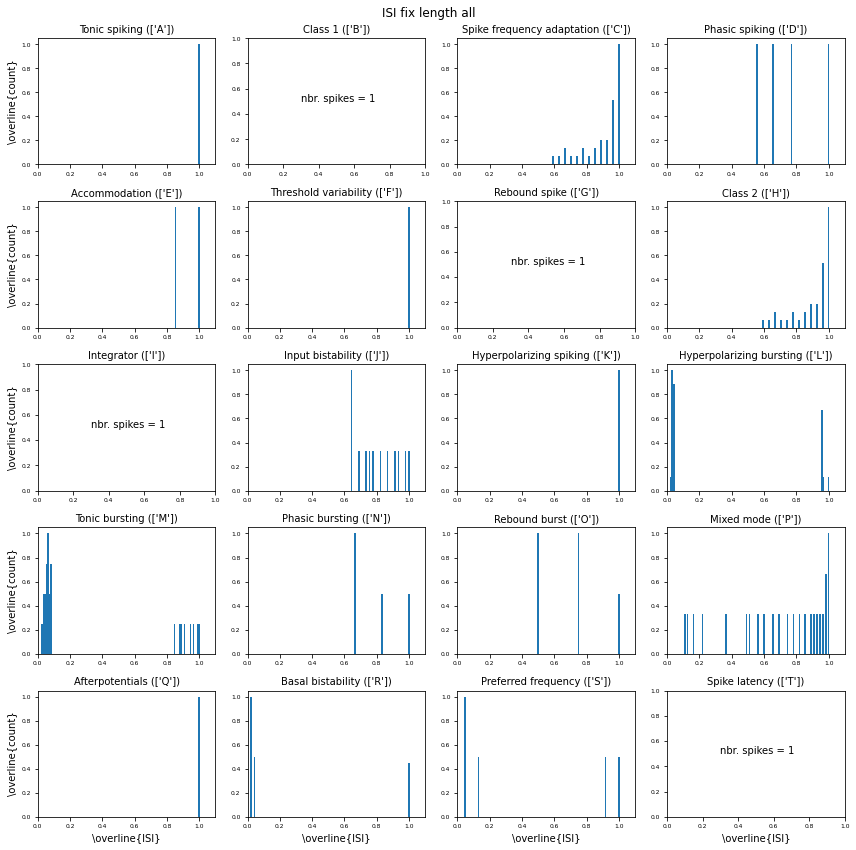

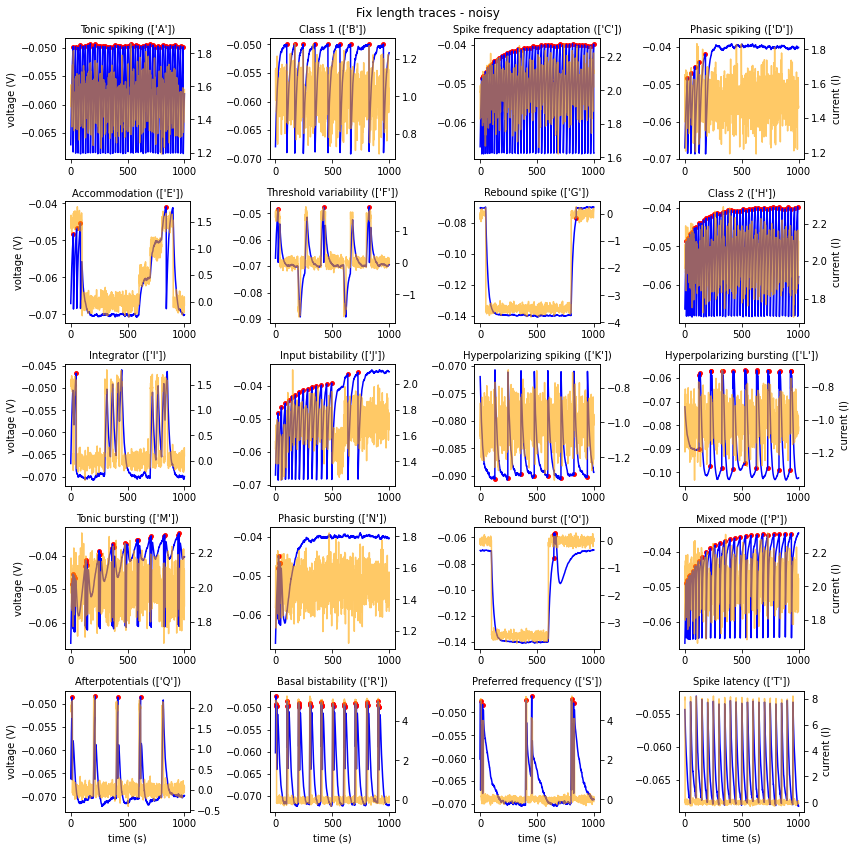

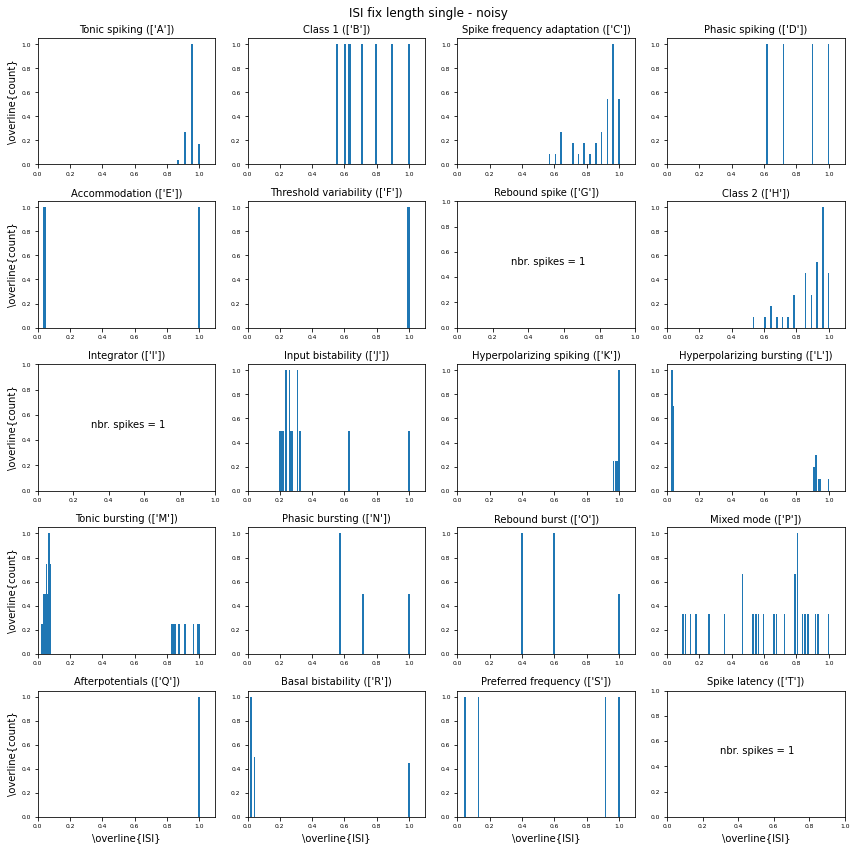

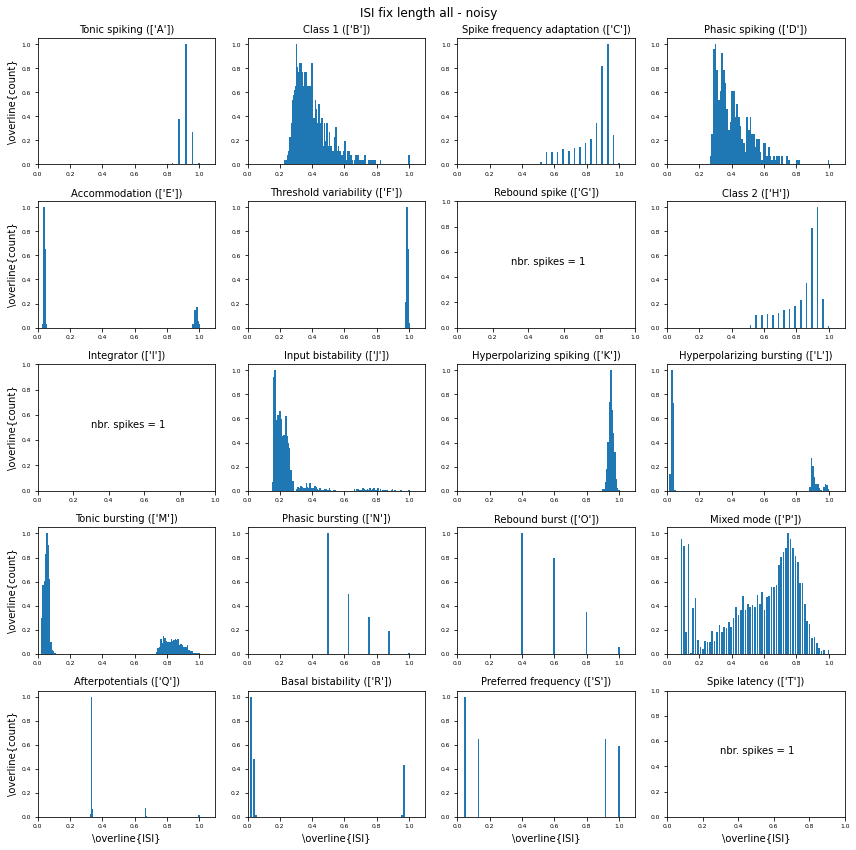

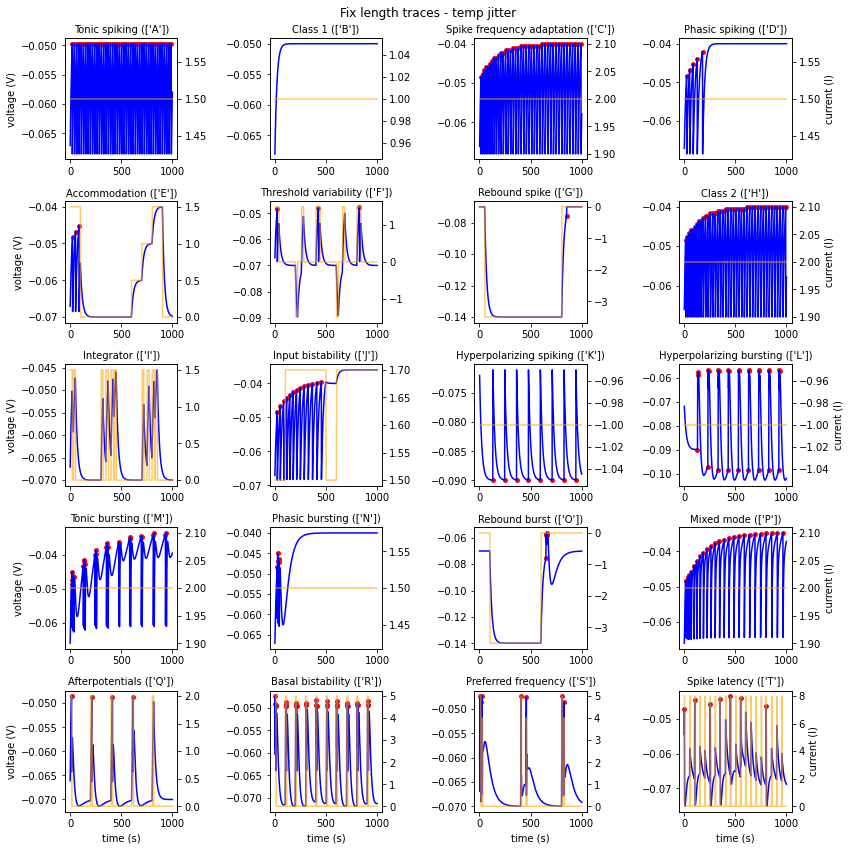

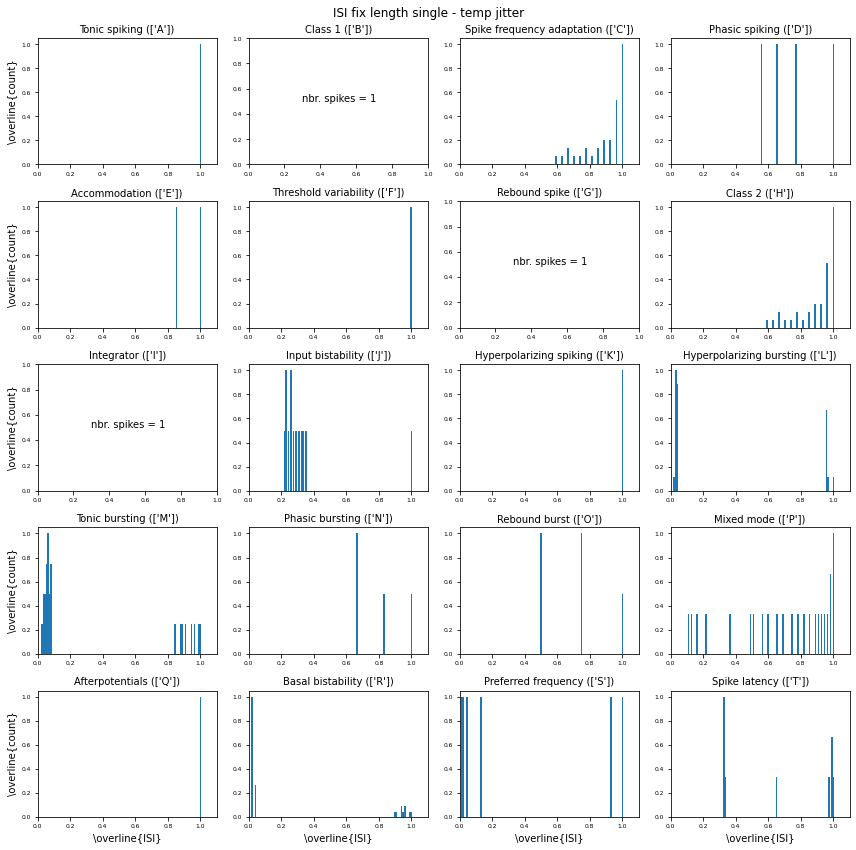

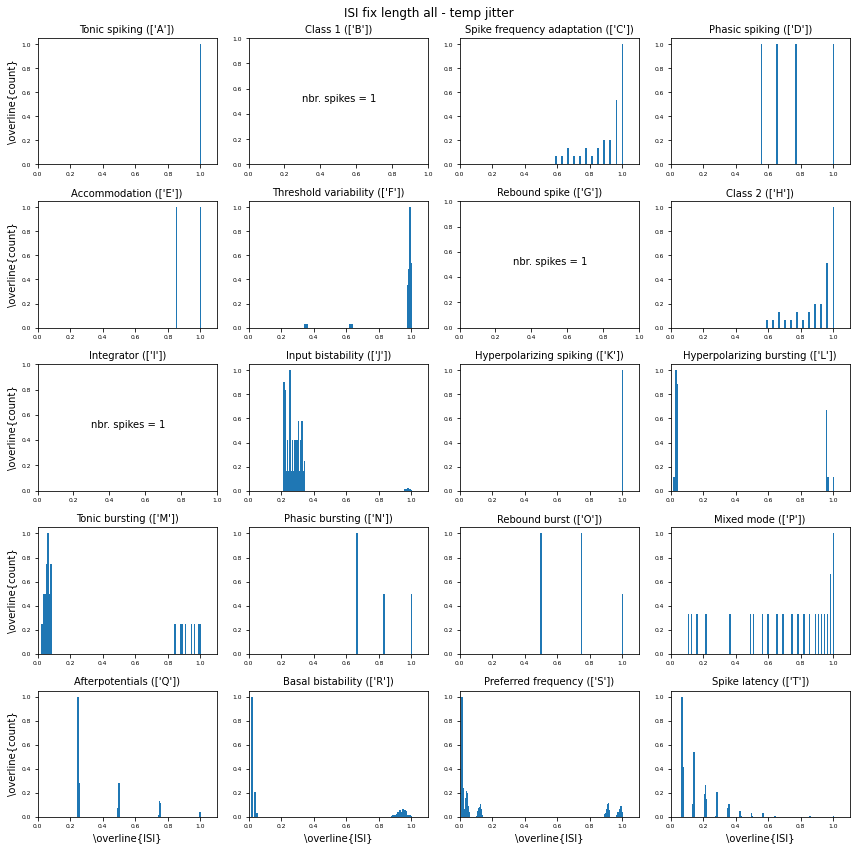

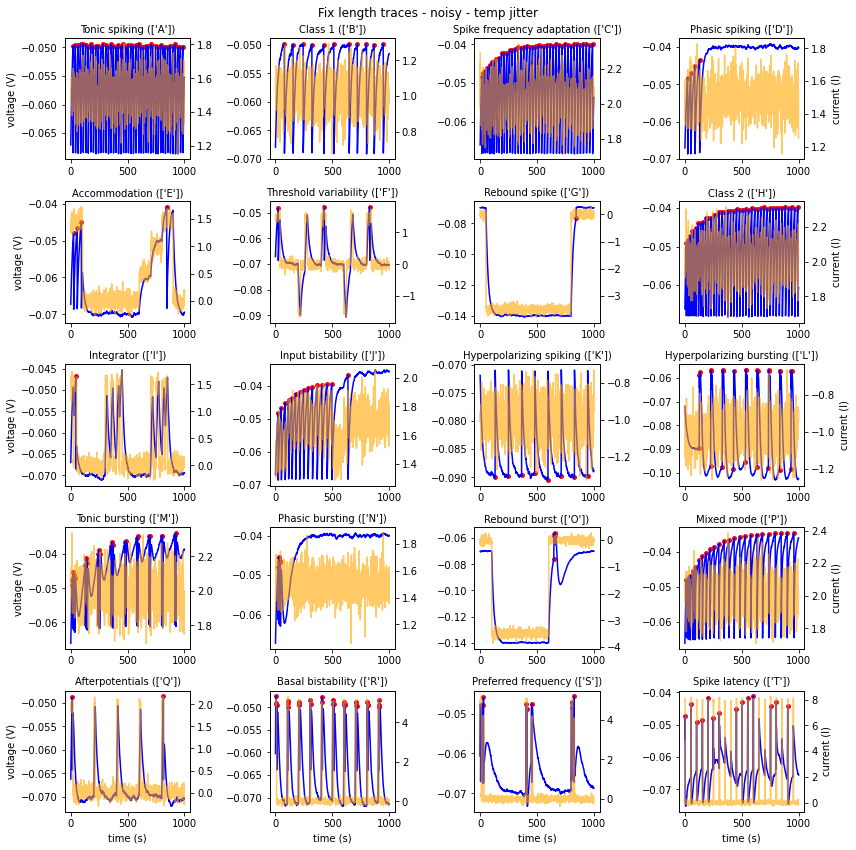

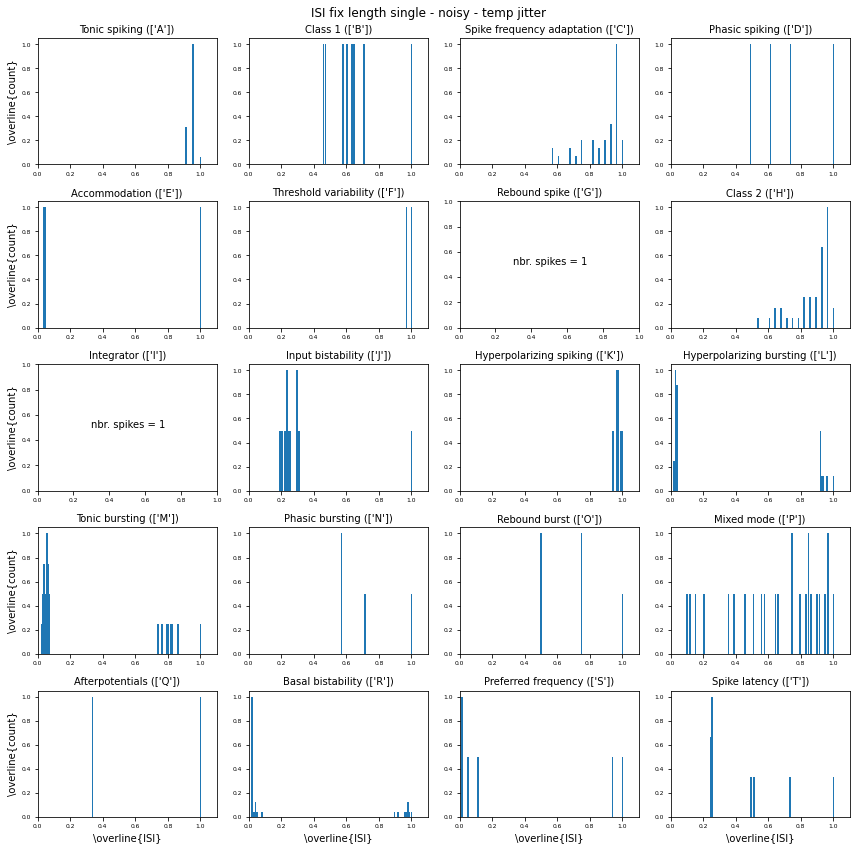

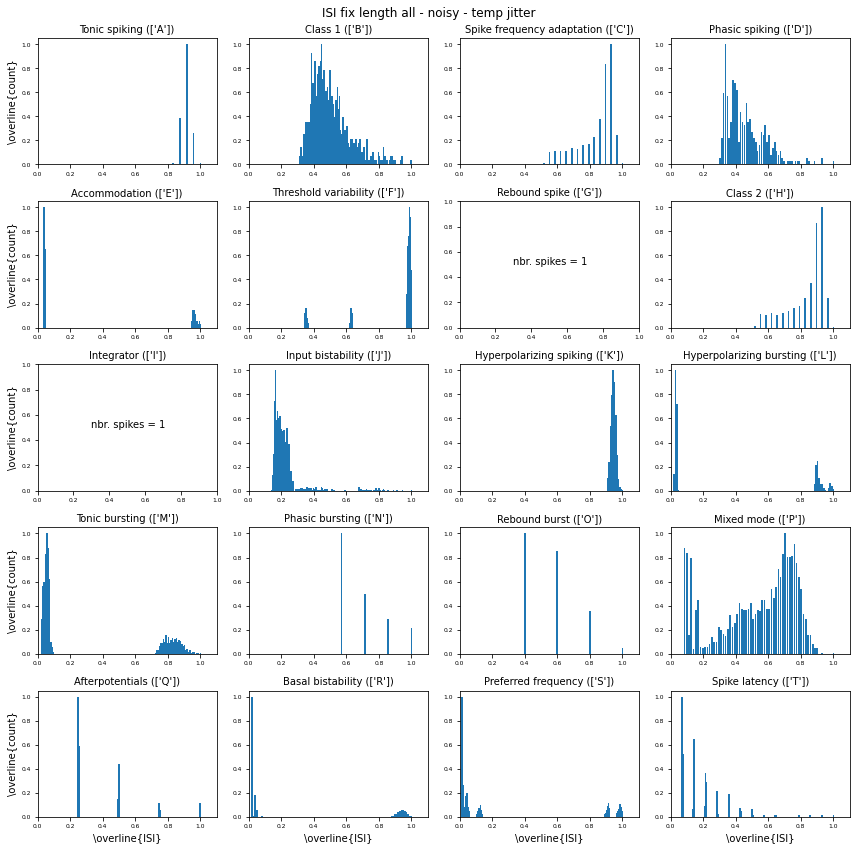

In [24]:
data_types = ['', '_noisy', '_temp_jitter', '_noisy_temp_jitter']

for _, data_type in enumerate(data_types):
    add_noise = False
    temp_jitter = False
    # set correct flags
    if data_type == '_noisy':
        add_noise = True
    elif data_type == '_temp_jitter':
        temp_jitter = True
    elif data_type == '_noisy_temp_jitter':
        add_noise = True
        temp_jitter = True

    filename = 'data_encoding_fix_len' + data_type
    infile = open(f"./data/{filename}.pkl", 'rb')
    data = pickle.load(infile)
    infile.close()
    # create plots
    plot_traces_fix_len(path, data, max_trials=max_trials,
                        add_noise=add_noise, temp_jitter=temp_jitter)

    plot_single_isi_fix_len(path, data, max_trials=max_trials,
                            add_noise=add_noise, temp_jitter=temp_jitter, norm_count=False, norm_time=False)
    plot_isi_fix_len(path, data, max_trials=max_trials,
                     add_noise=add_noise, temp_jitter=temp_jitter, norm_count=False, norm_time=False)

    plot_single_isi_fix_len(path, data, max_trials=max_trials,
                            add_noise=add_noise, temp_jitter=temp_jitter, norm_count=True, norm_time=False)
    plot_isi_fix_len(path, data, max_trials=max_trials,
                     add_noise=add_noise, temp_jitter=temp_jitter, norm_count=True, norm_time=False)

    plot_single_isi_fix_len(path, data, max_trials=max_trials,
                            add_noise=add_noise, temp_jitter=temp_jitter, norm_count=True, norm_time=True)
    plot_isi_fix_len(path, data, max_trials=max_trials,
                     add_noise=add_noise, temp_jitter=temp_jitter, norm_count=True, norm_time=True)


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.